# Session 1: Data wrangling and multivariate exploratory data analysis

This material is prepared for the Australian Water School by Luk Peeters (luk.peeters@csiro.au) and will be presented on June 3rd 2021.

The first session of the Python course focusses on data wrangling, importing and exporting various data sets and manipulating data within a Python environment. We'll illustrate this with hydrological time series data and hydrochemistry data sets. The next session will look in greater detail into time series analysis and visualisation. This session will use hydrochemistry data to showcase Python to do multivariate analysis and visualisation.

## 0. preamble
In the great Python slicing tradition, we start counting at 0. Before you can use any of the functionality of a package after you installed it, you need to load it. I prefer to have one code-block at the start of a notebook where I list all the packages I'm going to use. This is not absolutely necessary, but it makes it easier for others when sharing a notebook to quickly see which packages need to be installed.
There are two way to load a package:
1. import *package* as *short name*
2. from *package* import *function*

In [1]:
# preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import getcwd
# import functions we'll need later
from scipy.stats import rankdata
from sklearn.manifold import TSNE
# allow interactive figures in notebook
%matplotlib notebook

The codeblock above imports 3 packages we'll use a lot: numpy, pandas and matplotlib. To call any function in any of these packages, use the short name followed by a . and the name of the function. With the from *package* import *function* you can import a single function without prefix. The *getcwd* is a function of the os package that gives you the current working directory:

In [2]:
print(getcwd())

C:\Users\pee035\OneDrive - CSIRO\Projects\AWS Python course\Notebooks


The last line in the preamble ensures that matplotlib figures are displayed interactively in a notebook:

<IPython.core.display.Javascript object>


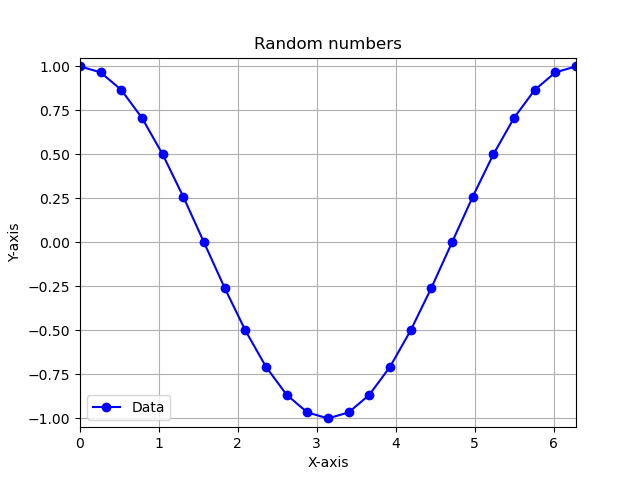

In [3]:
# create an array with 10 equally spaced points between 0 and 2pi
x = np.linspace(0, 2*np.pi, 25) 
# cosine of x
y = np.cos(x) 
# create an empty figure
fig, ax = plt.subplots() 
# plot x vs y, with blue line, with label for the legend
ax.plot(x,y,'-ob',label='Data') 
# title for the plot
ax.set_title('Random numbers') 
# x-label
ax.set_xlabel('X-axis') 
# y-label
ax.set_ylabel('Y-axis') 
# set x limits
ax.set_xlim(x.min(),x.max()) 
# set y limits
ax.set_ylim(-1.05,1.05) 
# add grid
ax.grid() 
# add legend
ax.legend() 

The plot display is interactive, i.e. you can zoom in and out, resize, pan and save the plot. The codeblock shows the basic elements to make a simple plot with matplotlib. A great resource is the [matplotlib cheatsheet](https://github.com/matplotlib/cheatsheets#cheatsheets). I often check the [matplotlib gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration to visualise data. We'll use this basic template throughout the session and tweak it where needed.

## 1. Importing and cleaning data - Streamflow time series
Most hydrological data is still stored in spreadsheets, either in ASCII-text files, csv-files or excel spreadsheets.
We've downloaded a csv file with streamflow discharge from Mt Barker in South Australia from the [Bureau of Meteorology website](http://www.bom.gov.au/waterdata/): **Q_A4260557.csv**. The file has over 40 years of daily data and is too large to open fully in excel.

We can open the file with numpy function [numpy.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) and [numpy.genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to create a numpy array:

In [14]:
Q = np.loadtxt('Q_A4260557.csv')

ValueError: could not convert string to float: '2008-01-02T08:09:00.000+09:30,0,10,102'

well, that didn't work - we need to use some more of the optional arguments

In [16]:
Q = np.loadtxt('Q_A4260557.csv',skiprows=11, delimiter=',', usecols = 1)

ValueError: could not convert string to float: ''

Still no luck. It seems like there is a missing value in the very last row. There are two ways around this; skip the last row or specify how to handle missing values. When you need more control on importing data, it is better to switch to `np.genfromtxt`:

In [17]:
Q = np.genfromtxt('Q_A4260557.csv',
                  delimiter=',',
                  skip_header=11,
                  skip_footer=1,
                  usecols = 1)

In [18]:
Q = np.genfromtxt('Q_A4260557.csv',
                  delimiter=',',
                  skip_header=11,
                  missing_values = '',
                  usecols = 1)

To check the data we've loaded, we can make a quick plot:

<IPython.core.display.Javascript object>


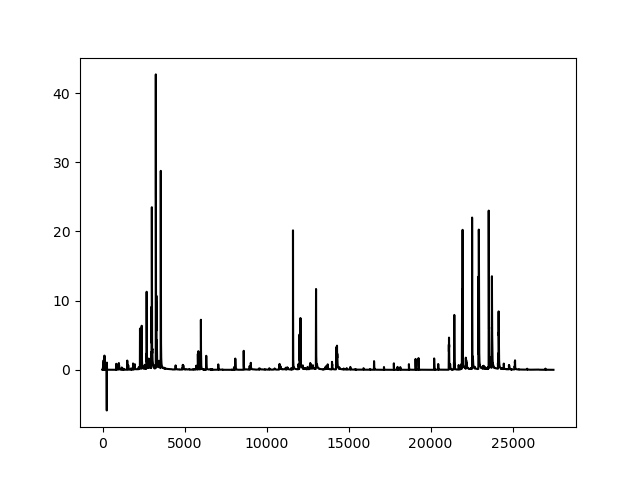

In [19]:
fig, ax = plt.subplots() # create an empty figure
ax.plot(Q,'-k')

This is obviously not yet a decent hydrograph. We haven't imported the dates or the additional information on the quality of each data point. It is possible to do this directly in numpy, but it is much easier to do that with pandas [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html):

In [4]:
Q = pd.read_csv('Q_A4260557.csv',
                header = 8, #which row to use for the headers
                index_col = 0, #which row to use as index
                parse_dates = True) # index is a data, parse it into a time series

In [21]:
Q.head() #quick look at dataframe

,Value,Quality Code,Interpolation Type
#Timestamp,,,
2008-01-02 08:09:00+09:30,0.0,10,102
2008-01-04 07:33:00+09:30,0.0,10,102
2008-01-07 12:00:00+09:30,0.0,10,102
2008-01-09 18:39:00+09:30,0.0,10,102
2008-01-15 23:15:00+09:30,0.0,10,102


<IPython.core.display.Javascript object>


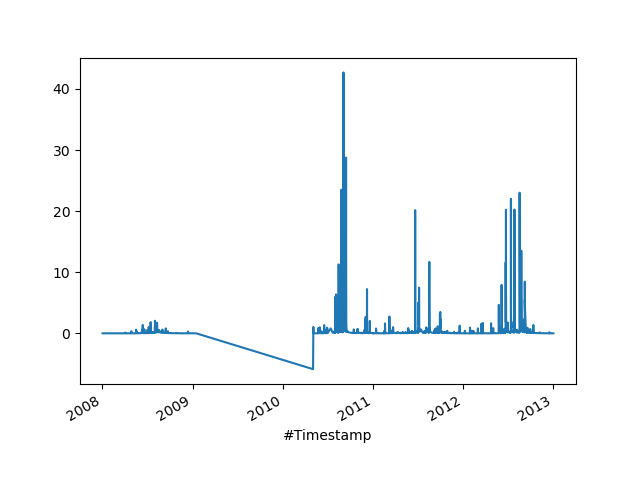

<AxesSubplot:xlabel='#Timestamp'>

In [22]:
# quick and dirty plot
plt.figure()
Q['Value'].plot()

This looks better, at least this is a hydrograph plot. As you zoom in on the plot, you'll see that the time axis updates as well. From the plot it is clear that there is a gap in the data in 2010, with negative values assigned to it.
There might be information in the quality code column. The quality codes are:

| Code | Label | Description |
|------|-------|:-------------|
|10 | quality-A | The record set is the best available given the technologies, techniques and monitoring objectives at the time of classification|
|90 | quality-B | The record set is compromised in its ability to truly represent the parameter |
|110 | quality-C | The record set is an estimate |
|140 | quality-E | The record set's ability to truly represent the monitored parameter is not known |
|210 | quality-F | The record set is not of release quality or contains missing data |

We can use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function to quickly cross-tabulate the percentage of data points in each category:

In [23]:
Q.groupby('Quality Code')['Value'].count()

Quality Code
-1          0
 10     27244
 110      135
 140        7
 210      101
Name: Value, dtype: int64

**Excercise: the dataset has a column with different codes used for the interpolation of data. Count the number of records for each class**

In [5]:
Q.groupby('Interpolation Type')['Value'].count()

Interpolation Type
101        0
102    27487
Name: Value, dtype: int64

To gain more insight, we can plot the hydrograph, color-coded by its quality label:

<IPython.core.display.Javascript object>


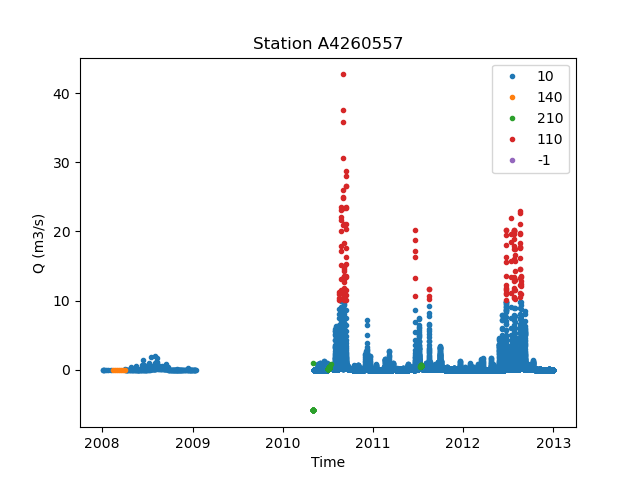

Text(0, 0.5, 'Q (m3/s)')

In [24]:
# list the unique quality code values
codes = Q['Quality Code'].unique()
# create new figure
fig,ax = plt.subplots()
# for loop, looping through the values in list codes
for code in codes:
    # find the indices of the records for quality code 'code'
    inds = Q['Quality Code']==code 
    # plot the selected values
    ax.plot(Q.index[inds],Q['Value'][inds],'.',label=code) 
# add legend, outside for loop
l = ax.legend()
# set title, xlabel and ylabel
ax.set_title('Station A4260557')
ax.set_xlabel('Time')
ax.set_ylabel('Q (m3/s)')

There are a couple of ways that we can clean this dataset:
1. Set all values below zero to NaN
2. Set all measurements with Quality Code 210 to NaN

<IPython.core.display.Javascript object>


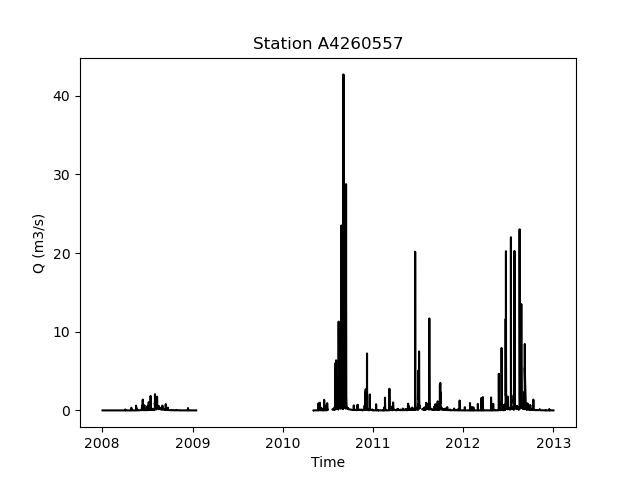

Text(0, 0.5, 'Q (m3/s)')

In [25]:
# set all values below zero to NaN
Q.loc[Q['Value']<0,'Value'] = np.nan
# set all values with quality code 210 to NaN
Q.loc[Q['Quality Code']==210,'Value'] = np.nan
# plot the result
fig,ax = plt.subplots()
ax.plot(Q.index,Q['Value'],'-k') 
ax.set_title('Station A4260557')
ax.set_xlabel('Time')
ax.set_ylabel('Q (m3/s)')

Now that we've cleaned the data, we can do some analysis, like for instance making a flow duration curve. This code block uses a lot of functions associated with the pandas dataframe: [pd.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

<IPython.core.display.Javascript object>


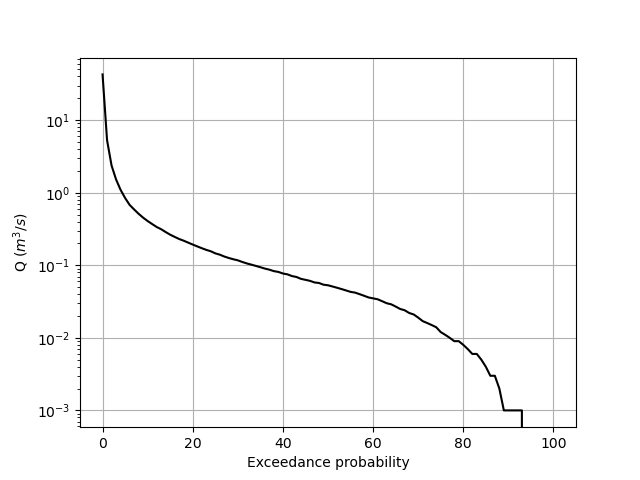

Text(0, 0.5, 'Q ($m^3/s$)')

In [26]:
#create an array with values from 0 to 1, in increments of 0.01
percs = np.arange(0,1.01,0.01)
# calculate percentiles, but remove NaN first
discharge = Q['Value'].dropna().quantile(percs)
# create a new data frame
flowduration = pd.DataFrame(index=percs,columns=['Exceedance Probability','Discharge']) 
# reverse order of quantiles
flowduration['Exceedance Probability'] = 100*(1-percs)
flowduration['Discharge'] = discharge[-1::]
#plot with log y axis
fig,ax = plt.subplots()
ax.semilogy(flowduration['Exceedance Probability'],flowduration['Discharge'],'-k')
ax.grid()
ax.set_xlabel('Exceedance probability')
# use Latex formatting
ax.set_ylabel(u'Q ($m^3/s$)') 

The code block above is pretty concise and gives you full control on calculating and plotting the flow duration curve. You might want to repeat this a lot. One way to do this without having to copy the code block over and over again is by creating a function:

In [27]:
def flowduration(Q):
    #create an array with values from 0 to 1, in increments of 0.01
    percs = np.arange(0,1.01,0.01)
    # calculate percentiles, but remove NaN first
    discharge = Q['Value'].dropna().quantile(percs)
    # create a new data frame
    flowduration = pd.DataFrame(index=percs,columns=['Exceedance Probability','Discharge']) 
    # reverse order of quantiles
    flowduration['Exceedance Probability'] = 100*(1-percs)
    flowduration['Discharge'] = discharge[-1::]
    #plot with log y axis
    fig,ax = plt.subplots()
    ax.semilogy(flowduration['Exceedance Probability'],flowduration['Discharge'],'-k')
    ax.grid()
    ax.set_xlabel('Exceedance probability')
    # use Latex formatting
    ax.set_ylabel(u'Q ($m^3/s$)') 
    return(flowduration,fig)

We'll use this function to illustrate how to save both the figure and the dataframe

<IPython.core.display.Javascript object>


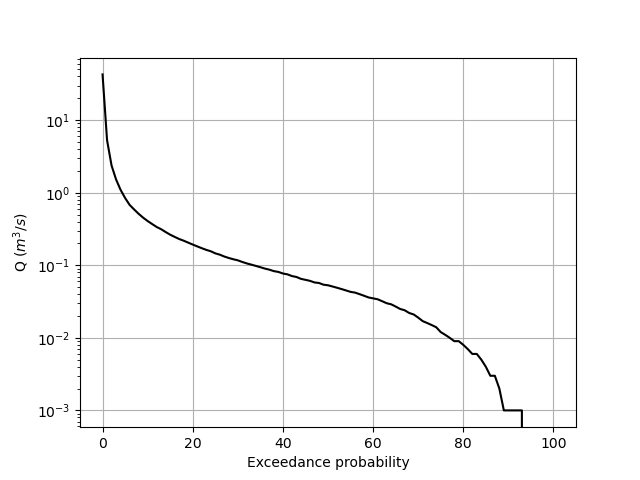

In [28]:
fd,fig = flowduration(Q)
# save figure as png
fig.savefig('Flowdurationcurve.png')
# save figure as csv file - index column by default has no label
fd.to_csv('Flowdurationcurve.csv', index_label='Percentile')

## 2 Intermezzo: inserting variables in strings
A great feature of using scripts is to automate tedious tasks, like loading different files or labeling figures with values from your data-set. Automating such tasks often requires inserting values from variables or arrays into strings. This section gives a quick overview of a couple of different ways to achieve that. A detailed overview can be found on the website [PyFormat](https://pyformat.info/)

The 'old' method you'll still often find is based on the '%' operator, while the new method is based on the format function of a string.

In [29]:
# create a string with the station name
name = 'A4260557'
# create a variable with a numeric value
Qmax = fd['Discharge'].max()

In [30]:
# insert the station name in a file name
# old
filename = 'Flow_duration_%s.csv' % (name)
print(filename)

Flow_duration_A4260557.csv


In [31]:
# new, all version of Python
filename = 'Flow_duration_{}.csv'.format(name)
print(filename)

Flow_duration_A4260557.csv


In [32]:
# new, Python >=3.6
filename = f'Flow_duration_{name}.csv'
print(filename)

Flow_duration_A4260557.csv


When you're adding numbers to a string, you can specify the format

In [33]:
# old
title = '%s: Qmax = %f m3/s' % (name,Qmax) # no formatting, just float
print(title)

A4260557: Qmax = 42.695000 m3/s


In [34]:
# new
title = '{}: Qmax = {:4.2f} m3/s'.format(name,Qmax) # 4 characters, 2 decimal places
print(title)

A4260557: Qmax = 42.70 m3/s


In [35]:
# new, Python >=3.6
title = f'{name}:\nQmax = {Qmax:04.0f} m3/s' # 4 characters, 0 decimal places, padding with zeros, \n for new line
print(title)

A4260557:
Qmax = 0043 m3/s


## 3 Multivariate data: reading from excel
Pandas can also read data directly from excel files, using [pd.read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html).
The dataset we are using is a dataset of groundwater chemistry of South Australia

[Gray, David J. and Bardwell, Nicole (2016) Hydrogeochemistry of South Australia: Data Release: Accompanying Notes. CSIRO, Australia. EP156116 34p](https://data.csiro.au/collections/collection/CIcsiro:17862v1)


In [2]:
fname = 'CSH_SA.xlsx'
sheet = 'Data'
chem = pd.read_excel(fname,sheet)
chem

,Drillhole,Date,Unit_No,Sample_No,CSIRO_No,Long,Lat,TDSc_mgL,pH,Eh_mV,...,18O_SMOW,2H_SMOW,Ra_BqL,13C_pmPDB,87Sr_rat,Alpha_BqL,Beta_BqL,14C_pmc,14C_age,222Rn_BqL
0,143,1941-07-18,473400001,97764,C00001,129.110034,-31.584249,159.870772,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,144,1941-07-18,473400002,1831820,C00002,129.346375,-31.521174,186.619224,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,146,1973-07-06,473400004,399452,C00003,129.385055,-31.640240,30817.910000,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,147,1973-06-30,473400005,1831822,C00004,129.157832,-31.665696,19035.280000,7.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,147,1973-07-21,473400005,399459,C00005,129.157832,-31.665696,18970.360000,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32292,276087,2013-02-26,653102002,2026137,C32338,138.008903,-33.159667,11192.837466,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32293,276089,2013-02-26,653102004,2026138,C32339,138.007531,-33.159979,40829.201102,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32294,276091,2013-02-26,653102006,2026135,C32340,138.011364,-33.160587,21575.757576,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32295,276092,2013-02-27,653102007,2026136,C32341,138.010962,-33.161361,26115.702479,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset has over 30.000 entries and 77 columns. Pandas has recognised the date column and converted these into dates. All the blanks in the dataset are converted to NaN, Not a Number.

The function pd.columns prints a list of all the columns in the dataframe:

In [3]:
chem.columns

Index(['Drillhole', 'Date', 'Unit_No', 'Sample_No', 'CSIRO_No', 'Long', 'Lat',
       'TDSc_mgL', 'pH', 'Eh_mV', 'DO_mgL', 'Temp_C', 'HCO3_mgL', 'Na_mgL',
       'K_mgL', 'Mg_mgL', 'Ca_mgL', 'Cl_mgL', 'SO4_mgL', 'Sr_mgL', 'Rb_mgL',
       'B_mgL', 'Br_mgL', 'NTot_mgL', 'NO3N_mgL', 'NInRedN_mgL', 'NRedN_mgL',
       'TKNN_mgL', 'DOC_mgL', 'F_mgL', 'P_mgL', 'Si_mgL', 'Li_mgL', 'Fe_mgL',
       'Mn_mgL', 'Al_mgL', 'Cu_mgL', 'Zn_mgL', 'Pb_mgL', 'As_mgL', 'Cr_mgL',
       'Cd_mgL', 'Ni_mgL', 'U_mgL', 'Ba_mgL', 'Co_mgL', 'Mo_mgL', 'Se_mgL',
       'V_mgL', 'Zr_mgL', 'I_mgL', 'Cs_mgL', 'Y_mgL', 'La_mgL', 'Ce_mgL',
       'Nd_mgL', 'Pr_mgL', 'Sm_mgL', 'Eu_mgL', 'Gd_mgL', 'Tb_mgL', 'Dy_mgL',
       'Tm_mgL', 'Er_mgL', 'Ho_mgL', 'Yb_mgL', 'Lu_mgL', '18O_SMOW', '2H_SMOW',
       'Ra_BqL', '13C_pmPDB', '87Sr_rat', 'Alpha_BqL', 'Beta_BqL', '14C_pmc',
       '14C_age', '222Rn_BqL'],
      dtype='object')

There are a lot of missing values in this dataframe. The next codeblock summarizes the percentage of records with missing values for each variable.

In [4]:
# number of records
nsample = len(chem)
# number of complete records
ncomplete = len(chem.dropna()) # dropna removes any row that contains at least one NaN
print('Number of records without missing values = {}'.format(ncomplete))

Number of records without missing values = 0


This dataset has no single record with entries for all variables. The first 7 variables are meta-data. We want to check if there are any records that only have data for the metadata, not for the chemistry. We can use the dropna function again. The next line of code removes any rows that are all NaN for all columns except the first 7.

In [5]:
chem.dropna(axis=0,how='all',subset=chem.columns[7::],inplace=True)
print('Number of records removed = {}'.format(nsample-len(chem)))

Number of records removed = 0


The next step is to cross-tabulate the number of missing values for each variable

In [6]:
chem_var_na = chem.isna().sum(axis=0).T
chem_var_na

Drillhole        0
Date           387
Unit_No          0
Sample_No        0
CSIRO_No         0
             ...  
Alpha_BqL    32170
Beta_BqL     32170
14C_pmc      32173
14C_age      32173
222Rn_BqL    32143
Length: 77, dtype: int64

An easier way to inspect that dataset is to plot it as a bar chart:

<IPython.core.display.Javascript object>


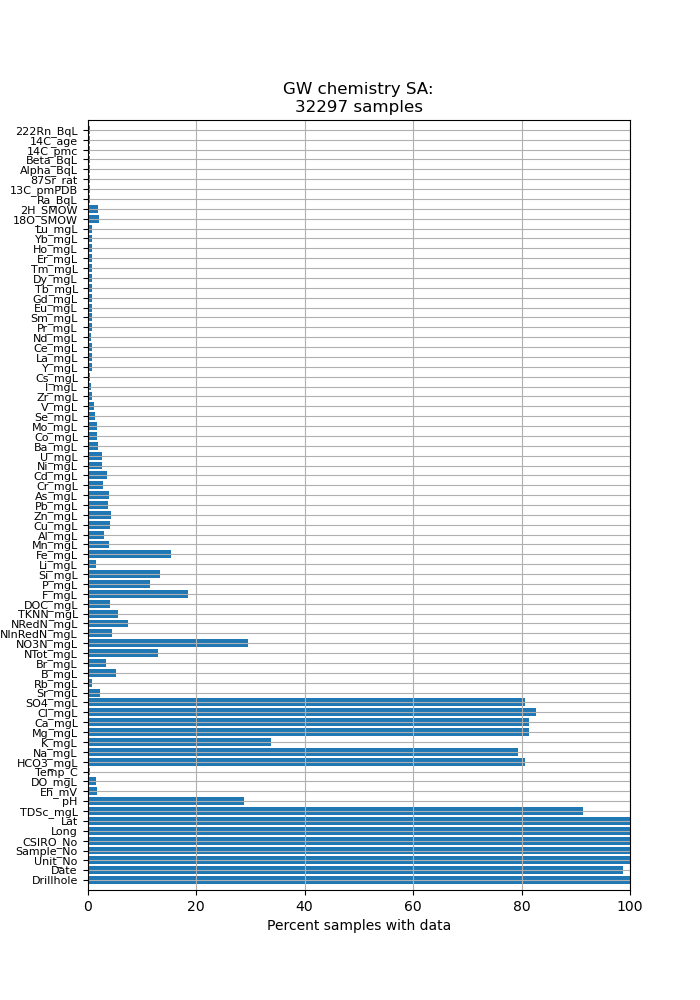

In [7]:
fig, ax = plt.subplots()
# modify the default figure size
fig.set_size_inches(7,10)
# create the ticks for a horizontal bar plot
ticks = np.arange(len(chem_var_na))
# bar plot of percent not NaN
ax.barh(ticks,
        100-100*(chem_var_na/float(nsample)))
# set labels for y-axis
ax.set_yticks(ticks)
ax.set_yticklabels(chem_var_na.index,fontdict={'fontsize':8})
# adjust y-axis limits
ax.set_ylim(-1,len(chem.columns))
# invert y-axis so meta-data is at the bottom
ax.invert_yaxis
# change x-axis limits
ax.set_xlim(0,100)
# set title
ax.set_title('GW chemistry SA:\n{} samples'.format(nsample))
# set x axis label
ax.set_xlabel('Percent samples with data')
# add grid
ax.grid()

We can also make a plot of how the number of samples with missing values changes through time

In [8]:
# same command as before, but now summing per row 
chem_sample_na = chem.isna().sum(axis=1)

<IPython.core.display.Javascript object>


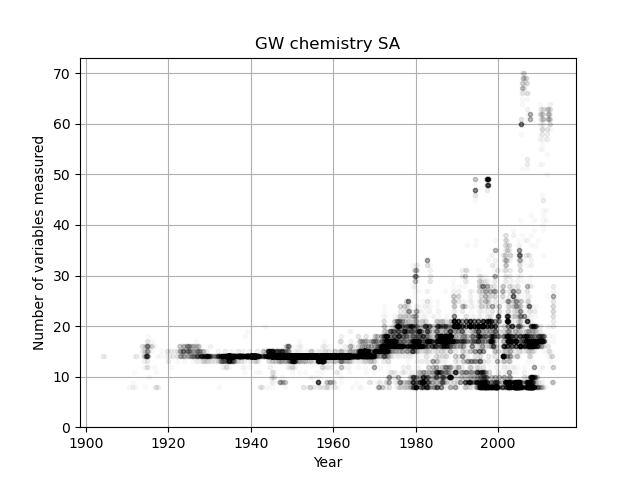

(0.0, 73.1)

In [9]:
fig, ax = plt.subplots()
# time series plot, using transparency as many points are overlapping
ax.plot(chem['Date'],(len(chem.columns)-chem_sample_na),'.k',alpha=0.02)
ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Number of variables measured')
ax.set_title('GW chemistry SA')
ax.set_ylim(bottom=0)

**Excercise 2: recreate the plot above, but without counting the 7 meta-data variables**

<IPython.core.display.Javascript object>


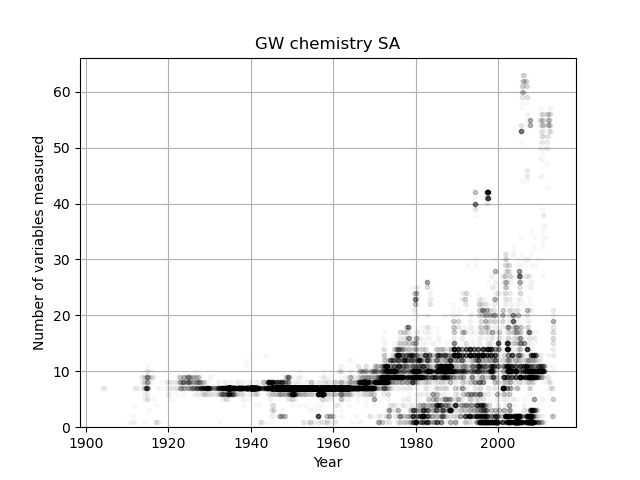

(0.0, 66.1)

In [10]:
# recalculate missing values without counting the 7 meta-data variables (which are the 1st 7 variables)
chem_sample_na = chem[chem.columns[7::]].isna().sum(axis=1)
# use the same plotting command but change the y-value in the plot command
fig, ax = plt.subplots()
# time series plot, using transparency as many points are overlapping
ax.plot(chem['Date'],(len(chem.columns[7::])-chem_sample_na),'.k',alpha=0.02)
ax.grid()
ax.set_xlabel('Year')
ax.set_ylabel('Number of variables measured')
ax.set_title('GW chemistry SA')
ax.set_ylim(bottom=0)

## 4. Exploratory Data Analysis
Exploratory data analysis is the process of visualising a dataset to formulate hypothesis of the processes that resulted in the data set.
Histograms are a standard visualisation to understand the distribution of variables. Python makes it very easy to generate multi-panel figures, so that you can summarise a lot of information in a single composite figure. Below is a code block to make histograms of the major ions:

<IPython.core.display.Javascript object>


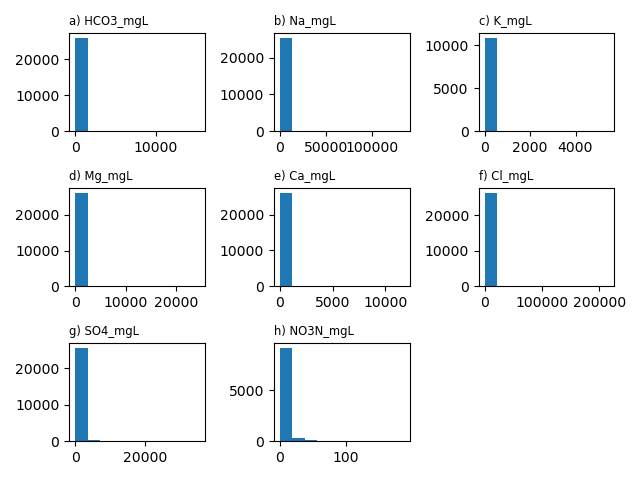

In [11]:
majorions = ['HCO3_mgL', 'Na_mgL','K_mgL', 'Mg_mgL', 'Ca_mgL', 'Cl_mgL', 'SO4_mgL','NO3N_mgL']
abc = 'abcdefghijklmnopqrstuvwxyz'
plt.figure()
# enumerate iterates a list and gives both the index (i) and the value (ion)
for i,ion in enumerate(majorions):
    # use the index here to select a subplot (it is the only function in python that is not 0 based :-( )
    plt.subplot(3,3,i+1) 
    # use the value here to select a column in the data frame
    plt.hist(chem[ion].dropna())
    # use the index to select letter and value here as title
    plt.title('{}) {}'.format(abc[i],ion),loc='left',fontsize='small')
# optional command to optimise the layout and size of labels of a multipanel plot
plt.tight_layout()

The histograms show that all data are very skewed. One quick way to deal with left-skewed data is to do a log transform first.

<IPython.core.display.Javascript object>


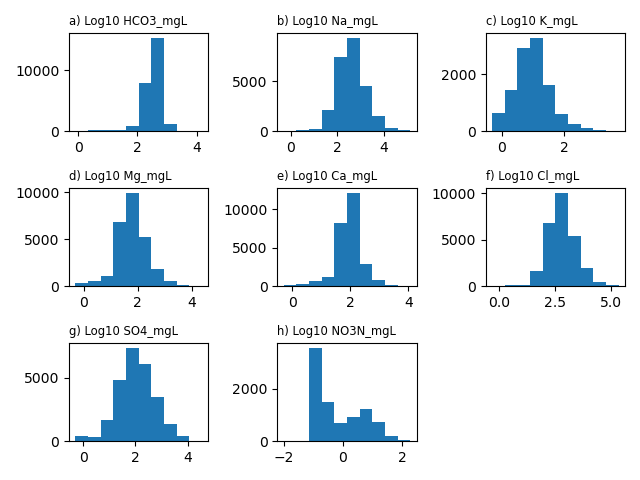

In [12]:
plt.figure()
for i,ion in enumerate(majorions):
    plt.subplot(3,3,i+1)
    # 0 values lead to error in log10
    plt.hist(np.log10(chem[ion][chem[ion]>0].dropna()))
    plt.title('{}) Log10 {}'.format(abc[i],ion),loc='left',fontsize='small')
plt.tight_layout()

This can be a misleading plot since all y-axis are different. It is possible to make all the y-axes the same, using `plt.subplots`. This however requires a rewrite of the `for` loop:

<IPython.core.display.Javascript object>


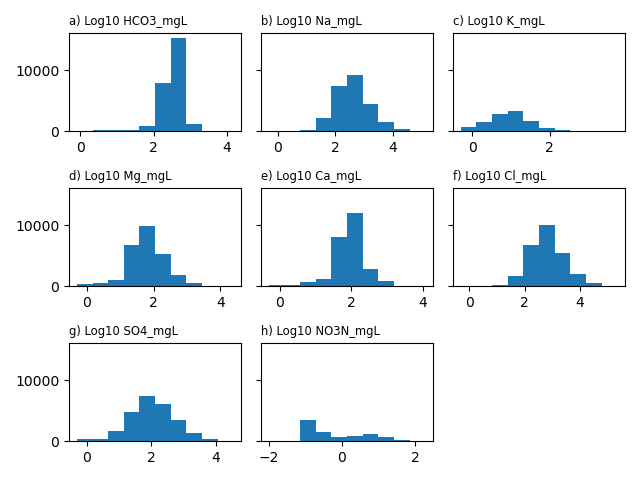

In [13]:
fig,axs = plt.subplots(nrows=3,ncols=3,sharey='all')
# axs is a 2D array, which is difficult to iterate over. ravel() turns it into a 1D array
axs = axs.ravel()
# we've created 9 subplots for 8 variables, so we have to delete the last one
axs[-1].remove()
# now we can iterate by directly calling the axis in which we want the subplot
for i,ion in enumerate(majorions):
    axs[i].hist(np.log10(chem[ion][chem[ion]>0].dropna()))
    # when calling plt.title on an axis, use the prefix 'set_' (this works for most plt. commands)
    axs[i].set_title('{}) Log10 {}'.format(abc[i],ion),loc='left',fontsize='small')
fig.set_tight_layout(True)

A more compact way to show distributions, especially if their scale is similar, is to use violinplots. Below is a violin plot for some of the minor ions:

<IPython.core.display.Javascript object>


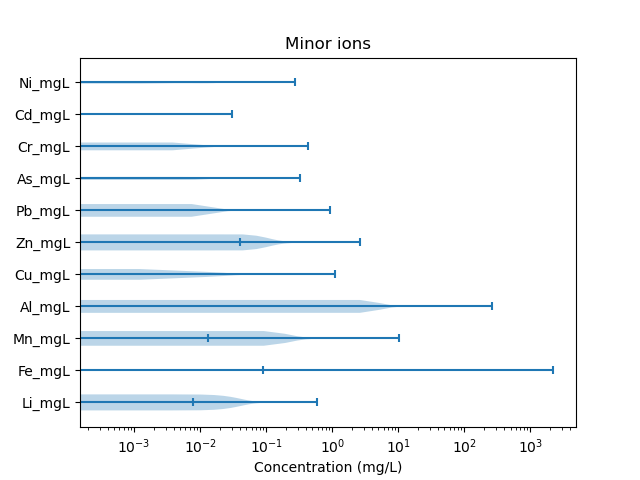

Text(0.5, 0, 'Concentration (mg/L)')

In [14]:
minorions = ['Li_mgL', 'Fe_mgL', 'Mn_mgL', 'Al_mgL', 'Cu_mgL', 'Zn_mgL', 'Pb_mgL', 'As_mgL', 'Cr_mgL','Cd_mgL', 'Ni_mgL']
fig,ax = plt.subplots()
d = [chem[a].dropna() for a in minorions]
ticks = np.arange(0,len(minorions))
ax.violinplot(d,positions=ticks,vert=False,showmedians=True)
ax.set_yticks(ticks)
ax.set_yticklabels(minorions)
ax.set_xscale('log')
ax.set_title('Minor ions')
ax.set_xlabel('Concentration (mg/L)')

Exploratory Data Analysis is also looking for correlations in the dataset. We might look into how some of the variables correlate with pH or TDS.

<IPython.core.display.Javascript object>


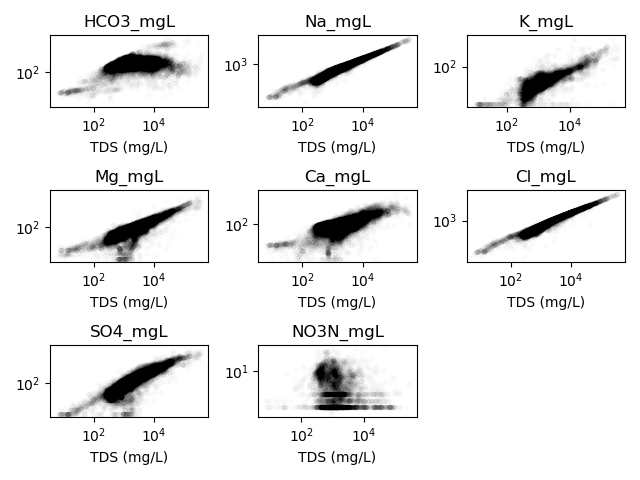

In [15]:
plt.figure()
for i,major in enumerate(majorions):
    plt.subplot(3,3,i+1)
    plt.loglog(chem['TDSc_mgL'],chem[major],'.k',alpha=0.01)
    plt.title(major)
    plt.xlabel('TDS (mg/L)')
plt.tight_layout()

**Excercise: make the same plot, but with pH on the x-axis**

<IPython.core.display.Javascript object>


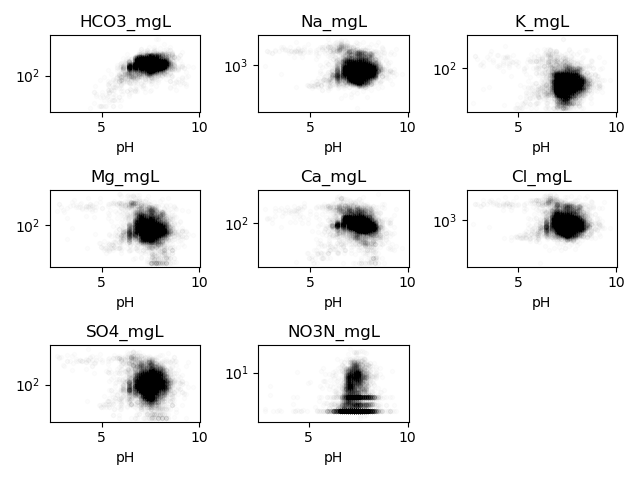

In [16]:
# same as above, with column pH
# changed to semilogy as pH is already on a log scale
plt.figure()
for i,major in enumerate(majorions):
    plt.subplot(3,3,i+1)
    plt.semilogy(chem['pH'],chem[major],'.k',alpha=0.01)
    plt.title(major)
    plt.xlabel('pH')
plt.tight_layout()

A more formal way of exploring correlations is through a correlation matrix.

In [17]:
chemcorr = chem[chem.columns[7::]].corr()
chemcorr_sp = chem[chem.columns[7::]].corr('spearman')
chemcorr

,TDSc_mgL,pH,Eh_mV,DO_mgL,Temp_C,HCO3_mgL,Na_mgL,K_mgL,Mg_mgL,Ca_mgL,...,18O_SMOW,2H_SMOW,Ra_BqL,13C_pmPDB,87Sr_rat,Alpha_BqL,Beta_BqL,14C_pmc,14C_age,222Rn_BqL
TDSc_mgL,1.000000,-0.216545,-0.011042,0.024937,0.222892,0.121240,0.994335,0.624617,0.866558,0.571960,...,0.435854,0.241667,0.081360,0.269174,-0.099959,0.297493,0.659460,-0.773812,0.862377,-0.051959
pH,-0.216545,1.000000,-0.295394,0.020688,-0.132971,0.185834,-0.219825,-0.173612,-0.261292,-0.206151,...,-0.023508,-0.106687,0.221509,0.362939,0.015697,-0.470176,-0.176089,0.217562,-0.258865,-0.040813
Eh_mV,-0.011042,-0.295394,1.000000,0.488355,-0.206363,-0.221920,-0.030848,0.000352,-0.037306,0.009782,...,0.147509,0.125903,0.153735,0.193130,0.028259,-0.399454,-0.316253,-0.163342,0.077740,0.048773
DO_mgL,0.024937,0.020688,0.488355,1.000000,-0.159548,-0.085387,0.010345,-0.005310,-0.014417,0.146319,...,0.263132,0.191456,0.052499,0.111976,-0.123572,-0.287834,-0.068254,-0.014708,-0.008956,0.116747
Temp_C,0.222892,-0.132971,-0.206363,-0.159548,1.000000,-0.125883,0.213797,0.208336,0.206700,0.159110,...,0.059338,-0.206360,NaN,0.345044,NaN,NaN,NaN,-0.334780,0.366470,-0.133221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Alpha_BqL,0.297493,-0.470176,-0.399454,-0.287834,NaN,-0.112067,0.285834,0.231715,0.147132,0.152684,...,0.173175,0.253524,NaN,NaN,NaN,1.000000,0.506690,NaN,NaN,NaN
Beta_BqL,0.659460,-0.176089,-0.316253,-0.068254,NaN,-0.207281,0.660752,0.913043,0.385868,0.203480,...,0.499716,0.483873,NaN,NaN,NaN,0.506690,1.000000,NaN,NaN,NaN
14C_pmc,-0.773812,0.217562,-0.163342,-0.014708,-0.334780,0.193999,-0.771610,-0.754469,-0.785968,-0.324522,...,-0.373917,-0.071324,0.272722,-0.330454,-0.254244,NaN,NaN,1.000000,-0.950812,-0.233617
14C_age,0.862377,-0.258865,0.077740,-0.008956,0.366470,-0.224925,0.862670,0.831134,0.877105,0.270807,...,0.387553,0.176330,-0.279646,0.246191,0.260521,NaN,NaN,-0.950812,1.000000,0.049877


For large dataset, visualising this as a colored matrix works well

<IPython.core.display.Javascript object>


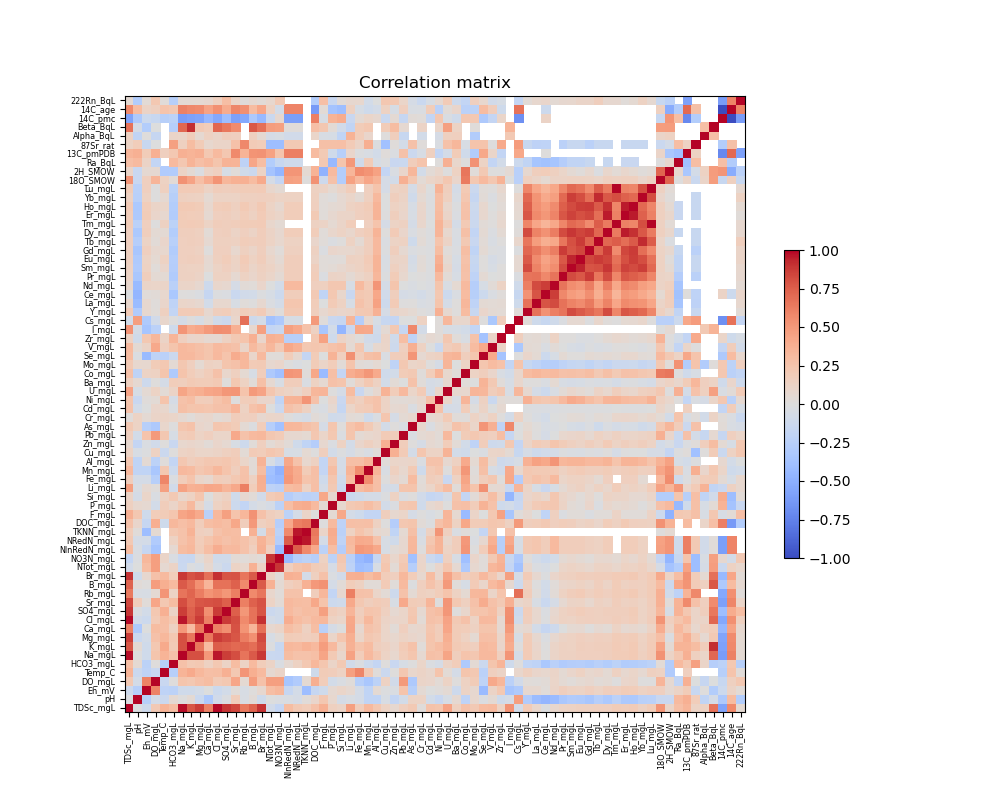

In [18]:
fig,ax = plt.subplots(figsize=(10,8))
q = ax.pcolor(chemcorr_sp,
          vmin=-1,vmax=1,
          cmap='coolwarm')
ax.set_title('Correlation matrix')
cbar = plt.colorbar(q,shrink=0.5)
a = ax.set_xticks(np.arange(len(chem.columns[7::]))+.5)
b = ax.set_xticklabels(chem.columns[7::],rotation=90,fontsize='xx-small')
c = ax.set_yticks(np.arange(len(chem.columns[7::]))+.5)
d = ax.set_yticklabels(chem.columns[7::],fontsize='xx-small')

## 5. Bringing in raster data
The package rasterio implements a lot of functionality importing and manipulating raster data. For this session however, we'll stick with numpy and pandas to showcase some general functionality on importing data and interacting with arrays.

The raster dataset we're using is a raster with estimated chloride deposition across Australia at a 0.05 degree grid.

[Davies, Phil; Crosbie, Russell. Mapping the spatial distribution of chloride deposition across Australia. Journal of Hydrology. 2018; 561:76-88. https://doi.org/10.1016/j.jhydrol.2018.03.051](https://data.csiro.au/collections/collection/CIcsiro:11068v4)

The chloride deposition rate in kg/ha/year (D) can be used together with the chloride concentration in groundwater (Cl) to estimate the recharge to groundwater (R) with the following equation:

R=100(D/Cl)

The raster is an ASCII grid file with following structure

    ncols         4
    nrows         6
    xllcorner     0.0
    yllcorner     0.0
    cellsize      50.0
    NODATA_value  -9999
    -9999 -9999 5 2
    -9999 20 100 36
    3 8 35 10
    32 42 50 6
    88 75 27 9
    13 5 1 -9999
    
We'll read the grid in with `np.loadtxt`. For the metadata (the 1st 6 line), we'll use the more generic `open` command together with `readline`:

In [19]:
# Chloride deposition grid
fname = 'cl_deposition_final.txt'
# read data in numpy array, skip metadata
cl_depo = np.loadtxt(fname,skiprows=6)
# create an empty dictionary for the meta-data
cl_depo_meta = {}
# open the grid file
with open(fname) as f:
    # while loop, as long as the dict has less than 6 entries
    while len(cl_depo_meta)<6:
        # readline reads 1 line in the file, the split function splits in a list based on white space
        tmp = f.readline().split()
        # first item in list is the name for the meta data, second is the value
        cl_depo_meta[tmp[0]] = float(tmp[1]) # use float to convert string to float

In [20]:
cl_depo_meta

{'ncols': 816.0,
 'nrows': 680.0,
 'xllcorner': 112.875000018,
 'yllcorner': -43.924999998,
 'cellsize': 0.050000001,
 'NODATA_value': -9999.0}

In [21]:
cl_depo_meta['ncols']

816.0

Replace the NODATA_values with NaN and plot the map with `imshow`

<IPython.core.display.Javascript object>


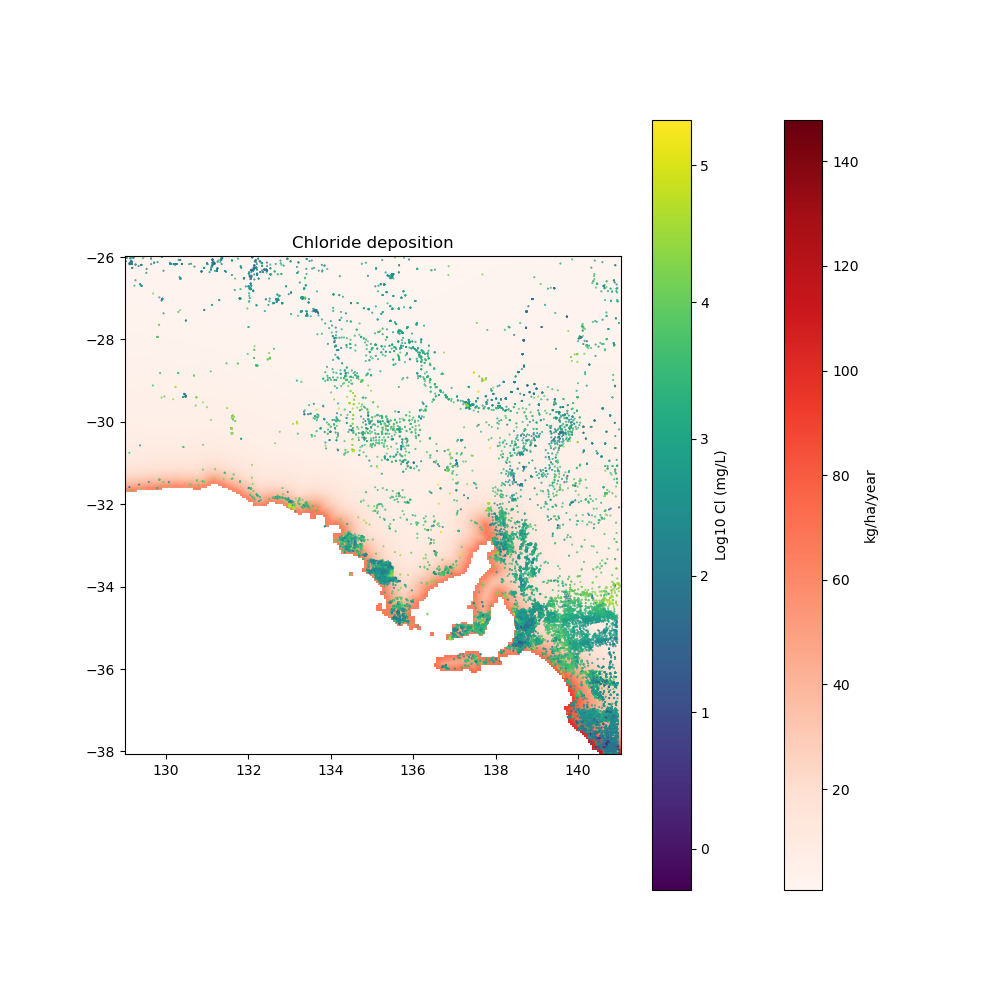

Text(0.5, 1.0, 'Chloride deposition')

In [22]:
cl_depo[cl_depo<(cl_depo_meta['NODATA_value']+1)] = np.nan
fig,ax = plt.subplots()
# modify the default figure size
fig.set_size_inches(10,10)
p = ax.imshow(cl_depo,
          origin = 'upper',
          cmap = 'Reds',
          extent = (cl_depo_meta['xllcorner'],
                   cl_depo_meta['xllcorner']+(cl_depo_meta['ncols']*cl_depo_meta['cellsize']),
                   cl_depo_meta['yllcorner'],
                   cl_depo_meta['yllcorner']+(cl_depo_meta['nrows']*cl_depo_meta['cellsize'])))
cbar = plt.colorbar(p)
cbar.set_label('kg/ha/year')
ax.set_title('Chloride deposition')

We can add the points from the chemistry dataset to the map and zoom in on the chemistry dataset

In [23]:
# zoom in to SA data
ax.set_xlim(chem['Long'].min(),chem['Long'].max())
ax.set_ylim(chem['Lat'].min(),chem['Lat'].max())
# use scatter to plot point with color based on log10 Cl
s = ax.scatter(chem['Long'],chem['Lat'],.2,np.log10(chem['Cl_mgL']),cmap='viridis')
# add second colorbar
cbars = plt.colorbar(s)
cbars.set_label('Log10 Cl (mg/L)')

To calculate the recharge rate at the sampling locations, we need to extract the values of the chloride deposition from the grid. For this we need to convert the coordinates of the samples into indices of the numpy array:

In [24]:
# setting up the coordinates of the grid based on the meta data
xmin = cl_depo_meta['xllcorner']
xmax = cl_depo_meta['xllcorner']+cl_depo_meta['cellsize']*cl_depo_meta['ncols']
ymin = cl_depo_meta['yllcorner']
ymax = cl_depo_meta['yllcorner']+cl_depo_meta['cellsize']*cl_depo_meta['nrows']
cell = cl_depo_meta['cellsize']
# the floor command rounds numbers down to the nearest integer. The astype('int') ensures the result is an integer
yind = (np.floor((chem['Long'] - xmin)/cell)).astype('int')
# the x-index of 0 is at the top of the grid, so we need to reverse the values
xind = (cl_depo_meta['nrows']-np.floor((chem['Lat'] - ymin)/cell)).astype('int')
chem['Cl_depo'] = cl_depo[xind,yind]

How do we know that our code is doing what we expect from it? One simple test is to visualise a copy of the grid and mark all the cells that have samples in, at least according to our calculations:

<IPython.core.display.Javascript object>


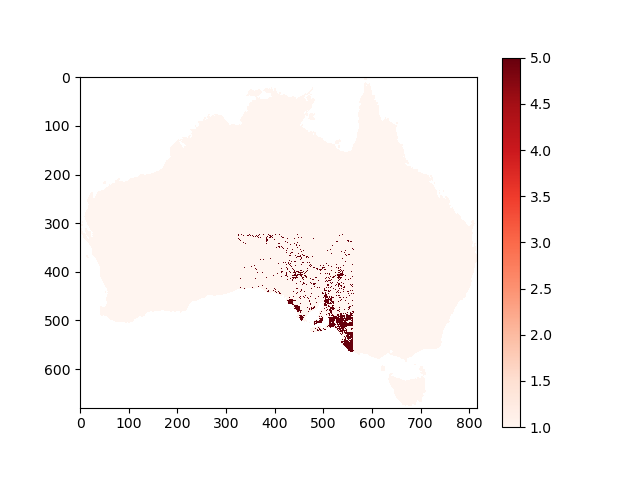

In [25]:
# create an empty array with same dimensions as cl_depo
a = np.zeros_like(cl_depo)*np.nan
# give all cells > 0 the value 1
a[cl_depo>0] = 1
# give all cells with a sample the value 5
a[xind,yind] = 5
# quick and dirty visualisation
plt.figure()
# use no interpolation to avoid pixels being affected by neighbours
plt.imshow(a,interpolation='none',cmap='Reds')
plt.colorbar()

**excercise: try to figure out what went wrong in selecting grid cells**

The x and y coordinates were swapped - they are the right way now.

We now have all the information to calculate the recharge rate from the chloride concentration:

<IPython.core.display.Javascript object>


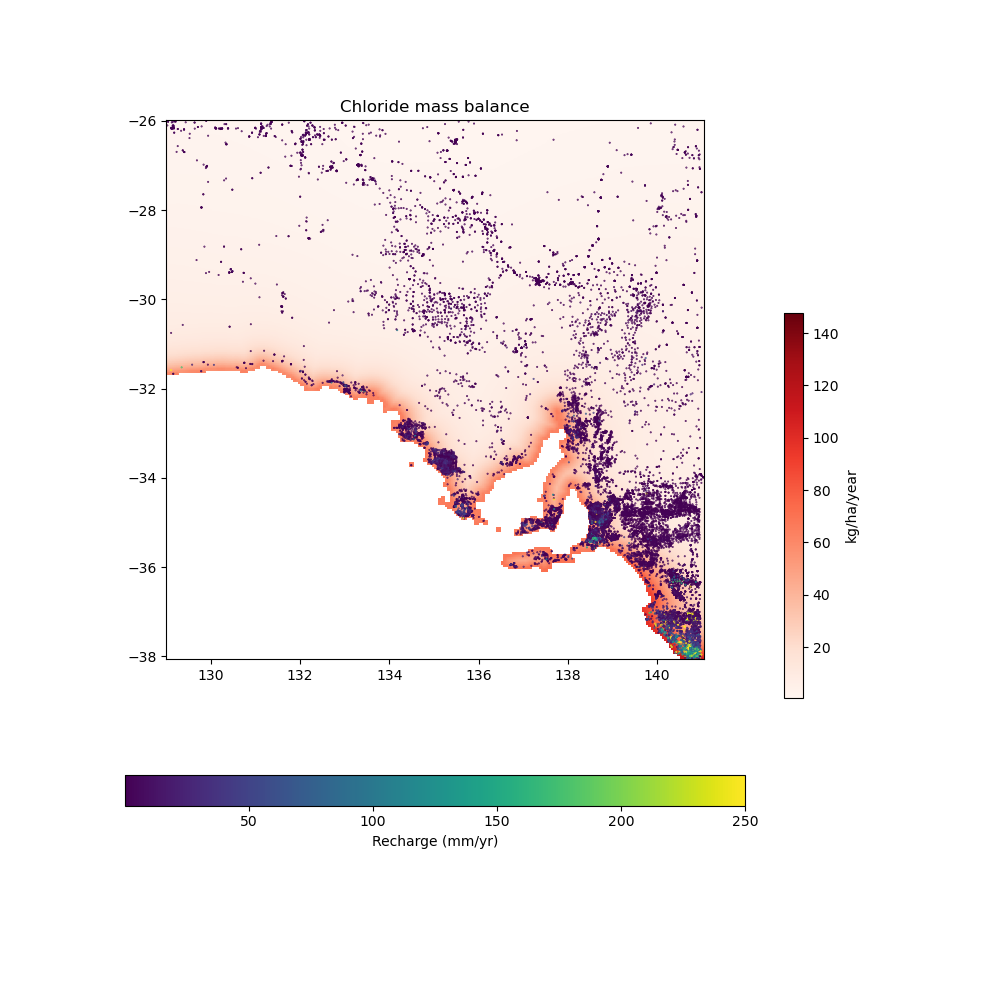

In [26]:
chem['Recharge'] = 100*(chem['Cl_depo']/chem['Cl_mgL'])

fig,ax = plt.subplots()
# modify the default figure size
fig.set_size_inches(10,10)
p = ax.imshow(cl_depo,
          origin = 'upper',
          cmap = 'Reds',
          extent = (cl_depo_meta['xllcorner'],
                   cl_depo_meta['xllcorner']+(cl_depo_meta['ncols']*cl_depo_meta['cellsize']),
                   cl_depo_meta['yllcorner'],
                   cl_depo_meta['yllcorner']+(cl_depo_meta['nrows']*cl_depo_meta['cellsize'])))
cbar = plt.colorbar(p, shrink=0.5)
cbar.set_label('kg/ha/year')
ax.set_title('Chloride mass balance')
# zoom in to SA data
ax.set_xlim(chem['Long'].min(),chem['Long'].max())
ax.set_ylim(chem['Lat'].min(),chem['Lat'].max())
# use scatter to plot point with color based on recharge
s = ax.scatter(chem['Long'],chem['Lat'],.2,chem['Recharge'],cmap='viridis',vmax=250)
# add second colorbar
cbars = plt.colorbar(s,orientation='horizontal')
cbars.set_label('Recharge (mm/yr)')

## 6 Intermezzo: Colors
Color is crucial in data visualisation, especially when using color to visualize a continuous range of data. Matplotlib has some excellent colormaps that are perceptually uniform and provides a great discussion and comparison of different [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

Related to choosing colormaps is choosing colors for categorical data or in plotting. [ColorBrewer](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) is a great tool to create color pallettes. Most plotting functions can use RGB or HexRGB values, but there is a range of named colors available. An overview is provided [here](https://matplotlib.org/stable/gallery/color/named_colors.html). The codeblock below is copied from that site.

<IPython.core.display.Javascript object>


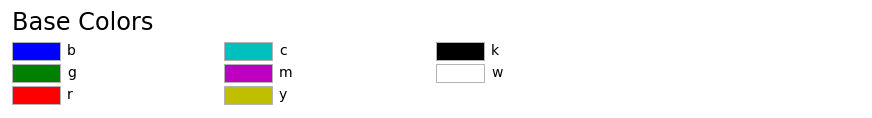

<IPython.core.display.Javascript object>


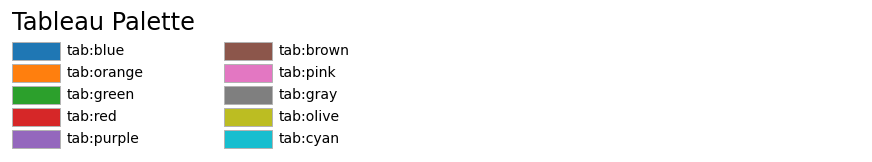

<IPython.core.display.Javascript object>


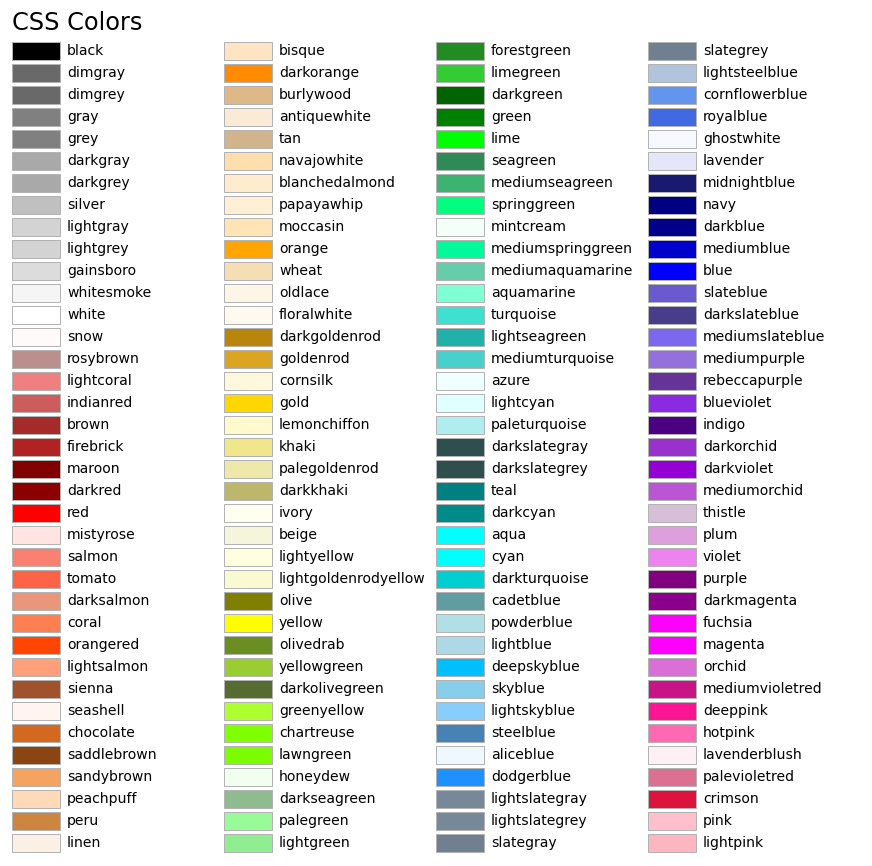

In [27]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)
plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)

plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

# Optionally plot the XKCD colors (Caution: will produce large figure)
#xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")
#xkcd_fig.savefig("XKCD_Colors.png")

plt.show()

**Excercise: make a plot of TDS vs pH with the datapoints colored 'darkseagreen'**

<IPython.core.display.Javascript object>


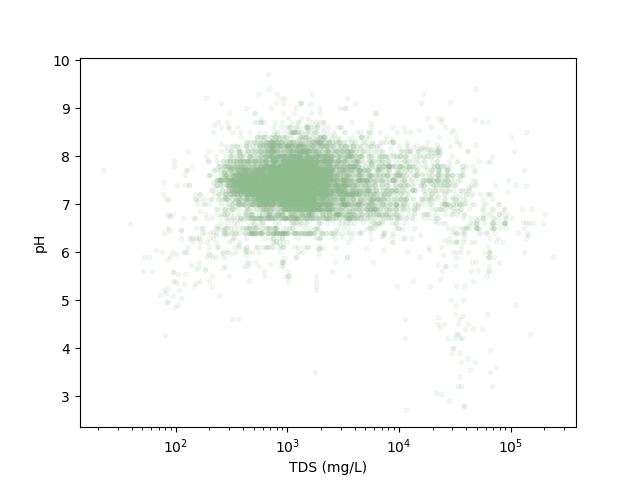

Text(0, 0.5, 'pH')

In [30]:
# 
f,s = plt.subplots()
s.semilogx(chem['TDSc_mgL'],chem['pH'],'.',color='darkseagreen',alpha=0.1)
s.set_xlabel('TDS (mg/L)')
s.set_ylabel('pH')

## 7. Multivariate data analysis

In [60]:
cols = ['Lat','Long','TDSc_mgL', 'pH', 'HCO3_mgL', 'Na_mgL', 'K_mgL', 'Mg_mgL', 'Ca_mgL', 'Cl_mgL', 'SO4_mgL','NO3N_mgL']
dat = chem[cols].dropna()
dat

,Lat,Long,TDSc_mgL,pH,HCO3_mgL,Na_mgL,K_mgL,Mg_mgL,Ca_mgL,Cl_mgL,SO4_mgL,NO3N_mgL
8,-26.659344,129.371098,1465.613547,6.96,349.007239,301.0,35.6,89.0,126.0,446.0,297.0,18.075029
25,-26.188945,129.399499,791.340000,8.00,426.000000,137.0,2.6,87.0,53.0,174.0,129.0,17.397215
34,-26.166874,129.132902,700.390000,8.20,461.000000,111.0,3.5,105.0,20.0,185.0,50.0,5.874384
40,-26.160120,129.121221,657.880000,8.10,432.000000,112.0,5.2,71.0,46.0,163.0,49.0,7.139636
41,-26.160120,129.121221,639.520000,7.60,418.000000,106.0,2.7,71.0,43.0,160.0,52.0,6.970000
...,...,...,...,...,...,...,...,...,...,...,...,...
32277,-33.667646,136.641977,8542.148760,6.72,475.894921,2460.0,69.8,392.0,179.0,4100.0,690.0,2.711254
32278,-30.466436,135.321646,1735.149429,7.37,260.917202,421.0,25.8,46.1,94.4,820.0,200.0,16.041588
32283,-29.999119,135.150827,2497.400000,8.00,160.000000,610.0,40.0,89.0,160.0,1100.0,420.0,29.000000
32286,-34.142167,135.306513,2858.111722,7.12,515.738208,767.0,22.4,112.0,164.0,1400.0,140.0,2.485316


As we've seen before, the data are very skewed. Before doing any multivariate data analysis it is therefore recommended to normalise data. This is often done by rescaling all variables so their range falls between 0 and 1 or by transforming the variables by subtracting the mean and dividing by the standard deviation. We used log transform earlier for skewed data. This has some drawbacks, especially if there are 0s in the dataset.

Another way to normalise data is to calculate the rank, i.e. the position if you were to rank them from smallest to largest. This can be easily done wiith the `rankdata` function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html).

In [61]:
# calculate rank of data
dr = rankdata(np.array(dat[cols[2::]]),axis=0)
dr

array([[2344. ,  613. , 1731. , ..., 1878.5, 3310. , 4161. ],
       [1050. , 3915. , 2721.5, ...,  652. , 2530. , 4149. ],
       [ 778. , 4117. , 3070.5, ...,  712. , 1230.5, 3643.5],
       ...,
       [3221. , 3915. ,  272.5, ..., 3228. , 3567. , 4242.5],
       [3335. , 1288. , 3383. , ..., 3415. , 2637.5, 3216. ],
       [3727. , 4033. , 2615. , ..., 3769. , 3265.5, 2727. ]])

There are a wide range of approaches for multivariate data analysis. A great resource is [scikit-learn](https://scikit-learn.org/stable/), which is an easy to use package for machine learning.

What we'll look into is dimensionality reduction and manifold learning. The goal is to find a representation of the data in 2D such that samples that are similar are plotted close to each other and samples that are very different are plotted far apart. The [manifold learning page](https://scikit-learn.org/stable/modules/manifold.html#manifold) gives an overview of methods you can use. The method we'll be using is [t-distributed Stochastic Neighbor Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE).

We need to import the function from scikit learn, specify the parameters and then train the algorithm with our dataset:

In [62]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')
X = tsne.fit_transform(dr)

The result is a 2D numpy array with an x and y coordinate for each sample. We can visualise this with `plt.scatter` and color the plot with the rank of each of the variables:

In [63]:
fig = plt.figure()
for i,col in enumerate(cols[2::]):
    ax = plt.subplot(4,3,i+1, aspect=1)
    ax.scatter(X[:,0],X[:,1],0.2,dr[:,i],cmap='viridis')
    ax.set_title(col)
    ax.set_axis_off()
plt.tight_layout()

<IPython.core.display.Javascript object>

This is a spatial dataset, so we want to know show this information on a map. I've developed a 2D perceptually colormap that can be used to assign a unique color to each sample, based on the coordinates of the TSNE projection:

In [64]:
def percuniform_rgb(x,y):
    '''
    Create RGB values for x,y positions from perceptually uniform colour scheme
    IN:
        x: [nx1] array of x values
        y: [nx1] array of y values
    OUT:
        rgb: [nx3] array of rgb values
    '''
    # rescale cartesian coordinates into range [-1,1]
    # normalise based on max(range(x),range(y))
    # multiply by 2 and subtract 1 to have data 
    # - centered on [0,0] 
    # - x and y each in range [-1,1]
    range_x = x.max()-x.min()
    range_y = y.max()-y.min()
    range_m = max(range_x,range_y)
    x_s = 2*((x-x.min())/range_m)-1
    y_s = 2*((y-y.min())/range_m)-1
    # load spline interpolant of colour scheme
    rgb_interp = np.load('BivariateColourScheme.npy', allow_pickle=True, encoding='latin1').item()
    # interpolate rgb values
    rgb = np.zeros((len(x),3))
    for i,col in enumerate(['R','G','B']):
        rgb[:,i] = np.clip(rgb_interp[col].ev(x_s,y_s),0,1)
    return(rgb)

In [65]:
tsnergb = percuniform_rgb(X[:,0],X[:,1])

<IPython.core.display.Javascript object>


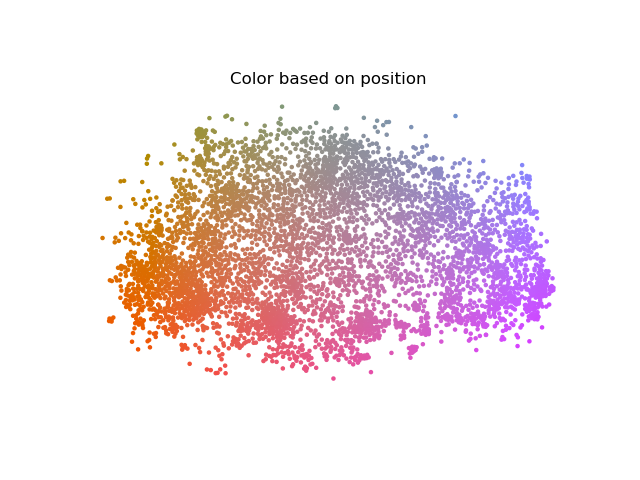

In [66]:
fig,ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],5,tsnergb)
ax.set_aspect('equal')
ax.set_title('Color based on position')
ax.set_axis_off()

We can now make a map of the samples, where each sample is colored based on its location in the TSNE plot

<IPython.core.display.Javascript object>


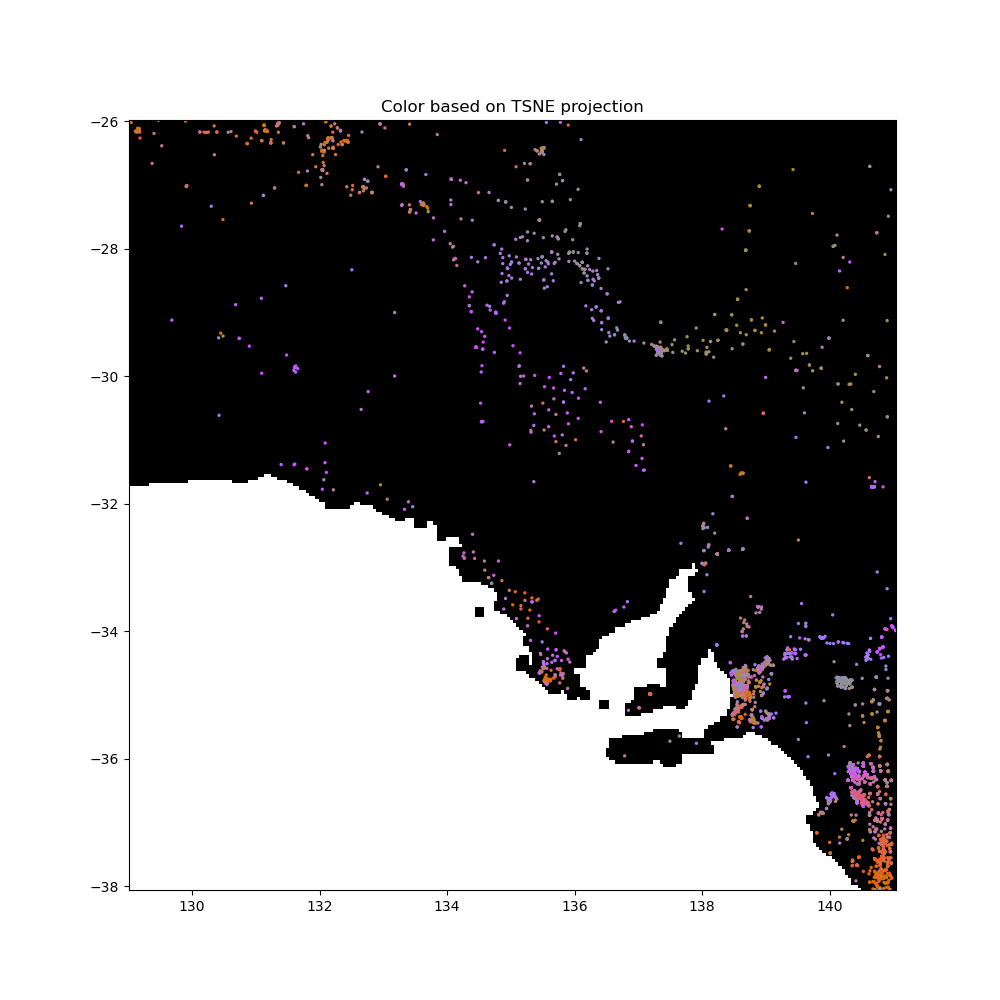

In [67]:
a = np.zeros_like(cl_depo)*np.nan
# give all cells > 0 the value 1
a[cl_depo>0] = 1

fig,ax = plt.subplots()
# modify the default figure size
fig.set_size_inches(10,10)

p = ax.imshow(a,
              origin = 'upper',
              cmap = 'gray',
              vmax = 2,
              extent = (cl_depo_meta['xllcorner'],
                        cl_depo_meta['xllcorner']+(cl_depo_meta['ncols']*cl_depo_meta['cellsize']),
                        cl_depo_meta['yllcorner'],
                        cl_depo_meta['yllcorner']+(cl_depo_meta['nrows']*cl_depo_meta['cellsize'])))
ax.set_title('Color based on TSNE projection')
# zoom in to SA data
ax.set_xlim(chem['Long'].min(),chem['Long'].max())
ax.set_ylim(chem['Lat'].min(),chem['Lat'].max())
# use scatter to plot point with color based on recharge
s = ax.scatter(dat['Long'],dat['Lat'],2,tsnergb)